In [3]:
# Step 1: Enable GPU
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU available: []


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Step 3: Load Dataset
import pandas as pd

# Load the CSV file from Google Drive
file_path = '/content/drive/MyDrive/Artificial_Intelligence/news_category.csv'
df = pd.read_csv(file_path)

# View basic info
print("Shape:", df.shape)
print("Columns:", df.columns)
df.head()


Shape: (11025, 2)
Columns: Index(['headline', 'category'], dtype='object')


,headline,category
0,How A New Documentary Captures The Complexity ...,CULTURE & ARTS
1,Twitch Bans Gambling Sites After Streamer Scam...,TECH
2,'Reboot' Is A Clever And Not Too Navel-Gazey L...,CULTURE & ARTS
3,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS
4,"Las Vegas Aces Win First WNBA Title, Chelsea G...",SPORTS


In [6]:
# Step 4: Text Preprocessing
import re
import nltk
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from wordcloud import WordCloud # Not used in current code
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# Download the missing data
nltk.download('punkt_tab') # Download the data for sentence tokenization

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Contraction handling (simple)
contractions = {
    "don't": "do not", "can't": "cannot", "won't": "will not", "i'm": "i am",
    "it's": "it is", "he's": "he is", "she's": "she is", "they're": "they are"
}

def clean_text(text):
    text = text.lower()
    for contraction, full in contractions.items():
        text = text.replace(contraction, full)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

df['cleaned'] = df['headline'].apply(clean_text)
df[['headline', 'cleaned']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,headline,cleaned
0,How A New Documentary Captures The Complexity ...,new documentary capture complexity child immig...
1,Twitch Bans Gambling Sites After Streamer Scam...,twitch ban gambling site streamer scam folk
2,'Reboot' Is A Clever And Not Too Navel-Gazey L...,reboot clever navelgazey look inside reboots
3,"Maury Wills, Base-Stealing Shortstop For Dodge...",maury will basestealing shortstop dodger dy
4,"Las Vegas Aces Win First WNBA Title, Chelsea G...",la vega ace win first wnba title chelsea gray ...


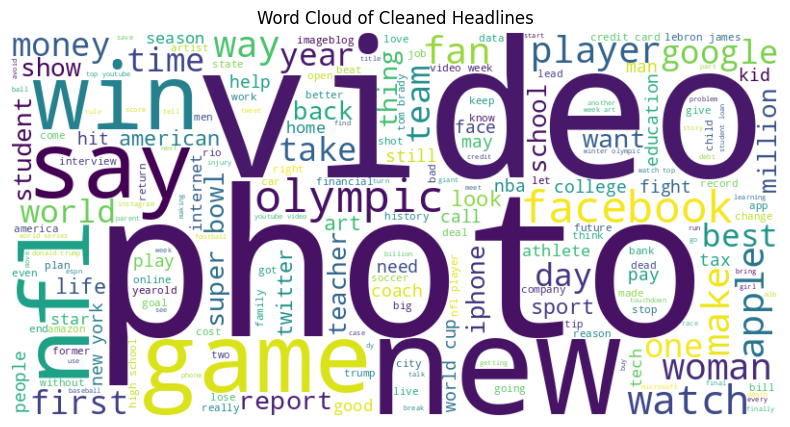

In [7]:
# Step 5: WordCloud Visualization
!pip install wordcloud
from wordcloud import WordCloud # Import WordCloud

all_words = ' '.join(df['cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Headlines")
plt.show()

In [8]:
# Step 6: Tokenization and Padding
from sklearn.model_selection import train_test_split
#from keras.preprocessing.text import Tokenizer # This import is outdated
from tensorflow.keras.preprocessing.text import Tokenizer # Import from tensorflow.keras instead
from tensorflow.keras.utils import pad_sequences # Import from tensorflow.keras instead
from sklearn.preprocessing import LabelEncoder

# Train-test split
X = df['cleaned'].values
y = df['category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine suitable max sequence length (90th percentile)
lengths = [len(seq) for seq in X_train_seq]
maxlen = int(np.percentile(lengths, 90))
print("90th Percentile Max Length:", maxlen)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

90th Percentile Max Length: 10


 **3.2 – Model Building and Training**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Constants
vocab_size = len(tokenizer.word_index) + 1  # Total words in tokenizer
embedding_dim = 100
input_length = X_train_pad.shape[1]
num_classes = len(np.unique(y_train_enc))


**Model 1: Simple RNN with Trainable Embedding**

In [10]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(num_classes, activation='softmax'))

model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_rnn = model_rnn.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_test_pad, y_test_enc),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5294 - loss: 1.1971 - val_accuracy: 0.8054 - val_loss: 0.6058
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9015 - loss: 0.3101 - val_accuracy: 0.8172 - val_loss: 0.6228
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9772 - loss: 0.0912 - val_accuracy: 0.8141 - val_loss: 0.6557
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9938 - loss: 0.0327 - val_accuracy: 0.8209 - val_loss: 0.7210


**Model 2: LSTM with Trainable Embedding**

In [11]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_test_pad, y_test_enc),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5013 - loss: 1.3346 - val_accuracy: 0.7524 - val_loss: 0.6648
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8316 - loss: 0.4657 - val_accuracy: 0.8413 - val_loss: 0.4873
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9567 - loss: 0.1502 - val_accuracy: 0.8336 - val_loss: 0.5717
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9843 - loss: 0.0663 - val_accuracy: 0.8295 - val_loss: 0.6940
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9901 - loss: 0.0367 - val_accuracy: 0.8259 - val_loss: 0.7762


**Model 3: LSTM with Pretrained Word2Vec Embeddings**                        
                                                                             
                                                                              
                                                                               
Step 1: Download and Load Word2Vec

In [12]:
import gensim.downloader as api
import numpy as np

# Load pre-trained word2vec (300-dimension)
w2v = api.load("word2vec-google-news-300")

embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in w2v:
        embedding_matrix[idx] = w2v[word]


[==================================================] 100.0% 1662.8/1662.8MB downloaded


Step 2: Build Model Using Pretrained Embeddings

In [15]:
from tensorflow.keras.layers import SpatialDropout1D

model_w2v = Sequential()
model_w2v.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=input_length,
    weights=[embedding_matrix],
    trainable=False  # Use pretrained weights without updating
))
model_w2v.add(SpatialDropout1D(0.2))
model_w2v.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_w2v.add(Dense(num_classes, activation='softmax'))

model_w2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_w2v = model_w2v.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_test_pad, y_test_enc),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5367 - loss: 1.1488 - val_accuracy: 0.8327 - val_loss: 0.5208
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8109 - loss: 0.5518 - val_accuracy: 0.8490 - val_loss: 0.4490
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8390 - loss: 0.4687 - val_accuracy: 0.8567 - val_loss: 0.4269
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8354 - loss: 0.4864 - val_accuracy: 0.8617 - val_loss: 0.4184
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8507 - loss: 0.4423 - val_accuracy: 0.8526 - val_loss: 0.4161
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8539 - loss: 0.4271 - val_accuracy: 0.8590 - val_loss: 0.4024
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8518 - loss: 0.4194 - val_accuracy: 0.8608 - val_loss: 0.4067
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8517 - loss: 0.4224 - val_accuracy: 0.86

**Task 3.3 — Training and Evaluation**


 Plotting Training vs Validation Loss & Accuracy

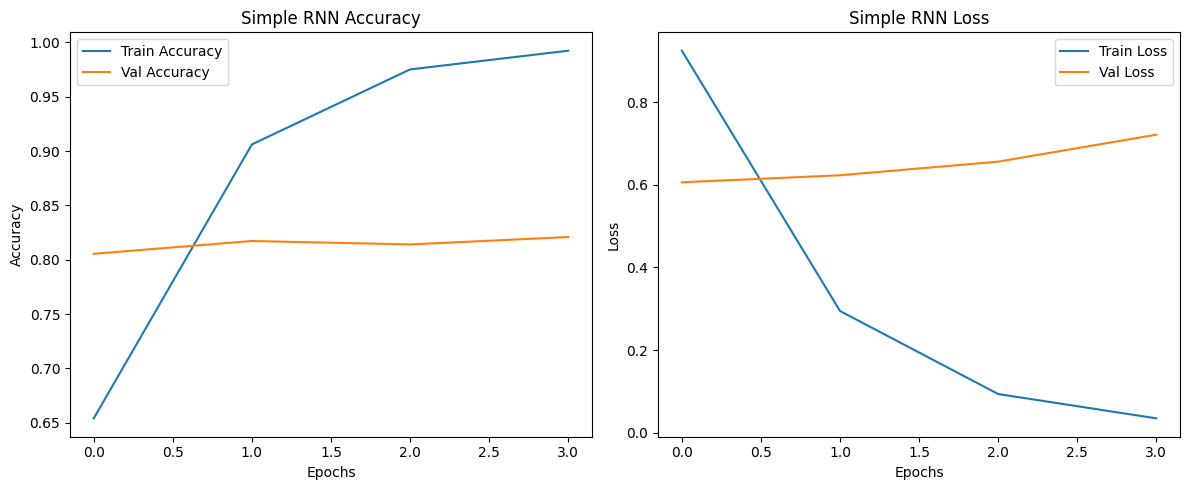

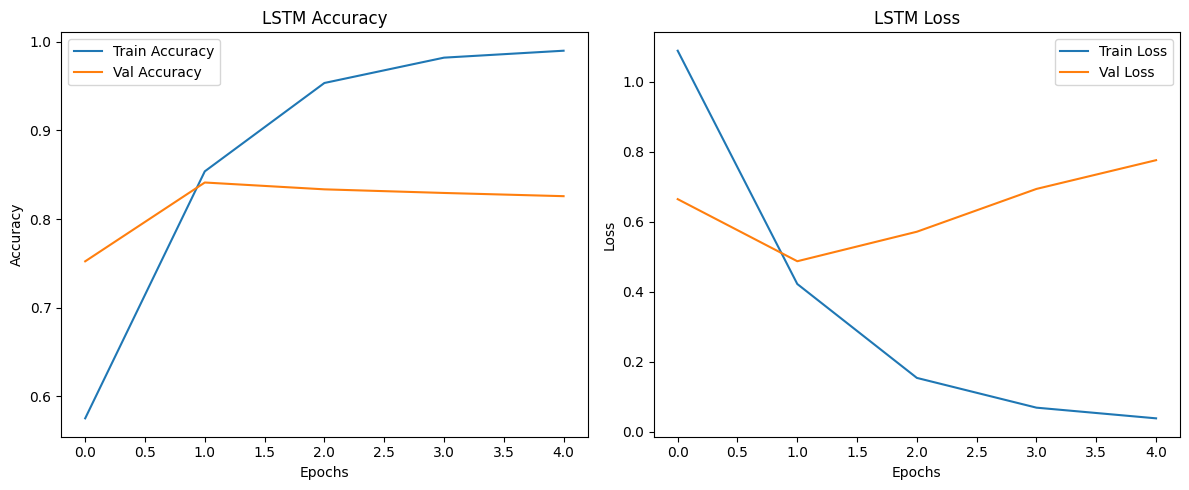

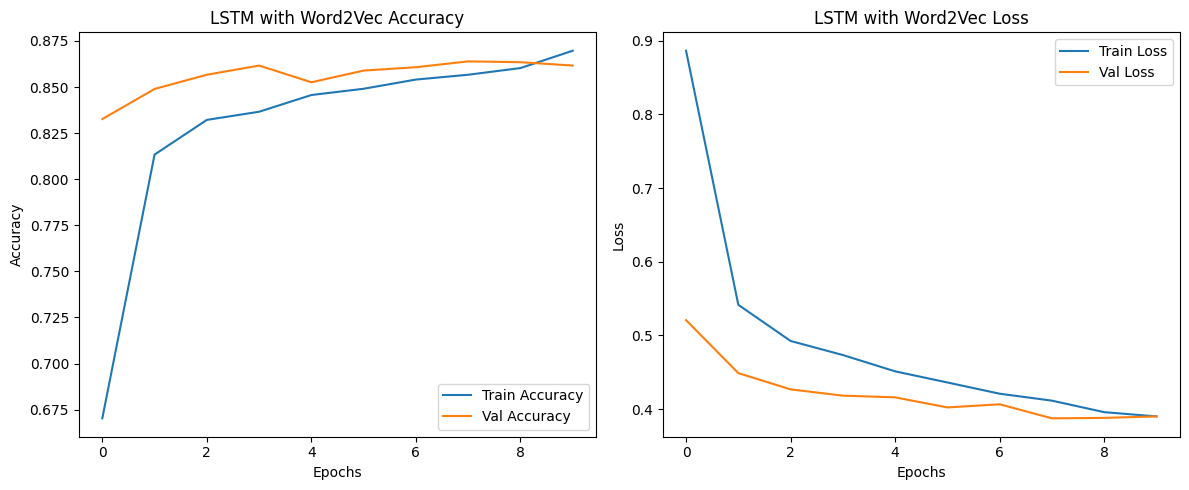

In [16]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot all histories
plot_history(history_rnn, "Simple RNN")
plot_history(history_lstm, "LSTM")
plot_history(history_w2v, "LSTM with Word2Vec")


Evaluate Models on Test Set

🔍 Evaluation for Simple RNN
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy: 0.8054421768707483

Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.72      0.64      0.68       224
     EDUCATION       0.67      0.46      0.55       193
         MONEY       0.71      0.72      0.72       338
        SPORTS       0.86      0.96      0.91      1020
          TECH       0.81      0.75      0.78       430

      accuracy                           0.81      2205
     macro avg       0.75      0.71      0.72      2205
  weighted avg       0.80      0.81      0.80      2205



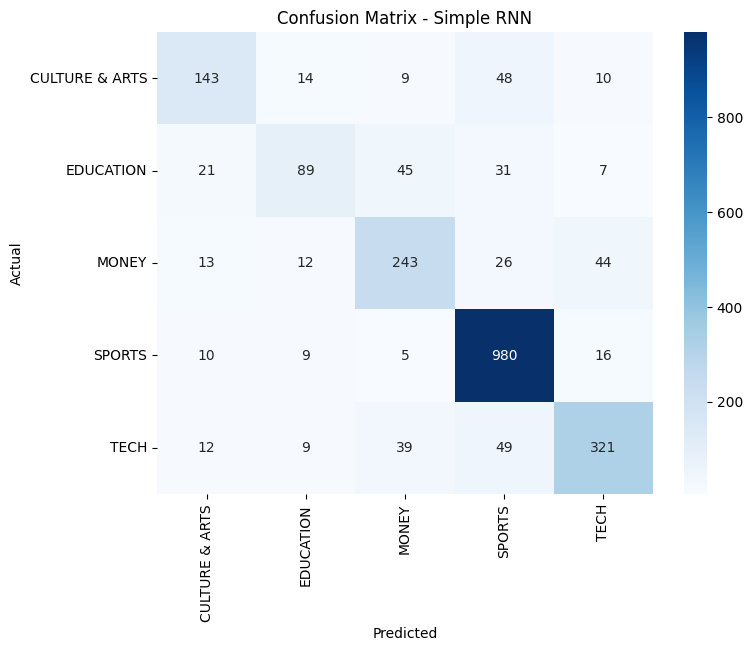

🔍 Evaluation for LSTM
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy: 0.8412698412698413

Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.84      0.71      0.77       224
     EDUCATION       0.73      0.66      0.69       193
         MONEY       0.71      0.79      0.75       338
        SPORTS       0.91      0.95      0.93      1020
          TECH       0.84      0.77      0.80       430

      accuracy                           0.84      2205
     macro avg       0.80      0.78      0.79      2205
  weighted avg       0.84      0.84      0.84      2205



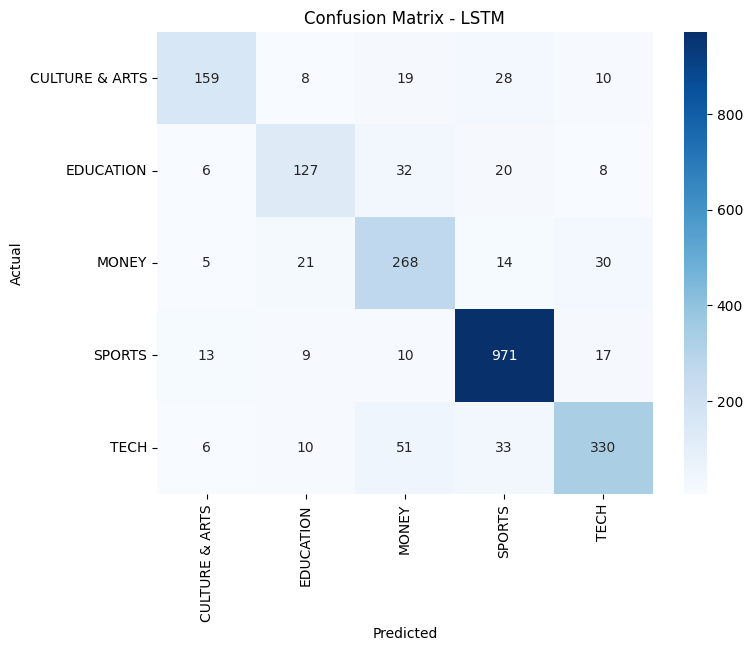

🔍 Evaluation for LSTM with Word2Vec
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Accuracy: 0.8639455782312925

Classification Report:
                precision    recall  f1-score   support

CULTURE & ARTS       0.79      0.78      0.78       224
     EDUCATION       0.80      0.70      0.75       193
         MONEY       0.83      0.82      0.83       338
        SPORTS       0.91      0.94      0.92      1020
          TECH       0.85      0.82      0.83       430

      accuracy                           0.86      2205
     macro avg       0.84      0.81      0.82      2205
  weighted avg       0.86      0.86      0.86      2205



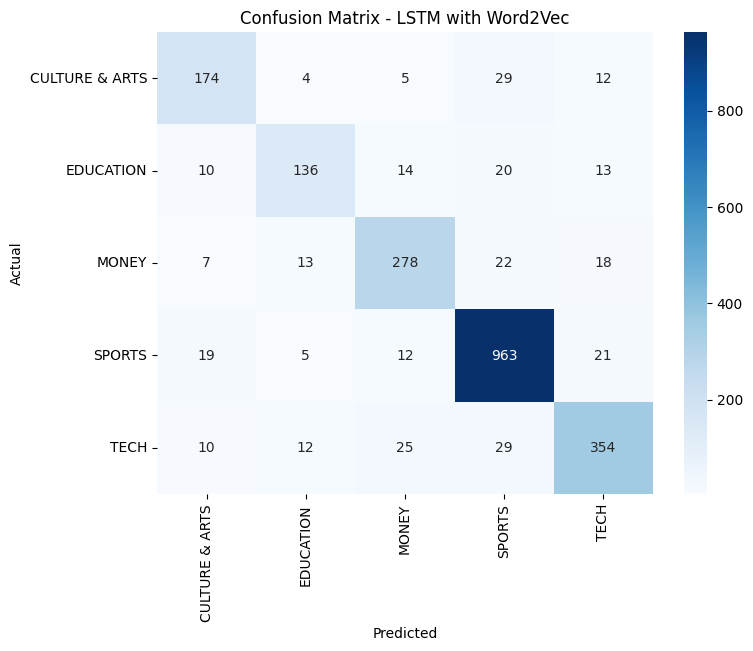

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    print(f"🔍 Evaluation for {model_name}")

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Accuracy
    acc = accuracy_score(y_test, y_pred_labels)
    print("Accuracy:", acc)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluating all three models
evaluate_model(model_rnn, X_test_pad, y_test_enc, "Simple RNN")
evaluate_model(model_lstm, X_test_pad, y_test_enc, "LSTM")
evaluate_model(model_w2v, X_test_pad, y_test_enc, "LSTM with Word2Vec")


**Task 3.4 — Real-Time Prediction GUI using Gradio**

In [18]:
!pip install gradio --quiet
import gradio as gr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


Preprocess Function

In [19]:
def preprocess_input(text):
    text = text.lower()
    for contraction, full in contractions.items():
        text = text.replace(contraction, full)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)


Define Prediction Function (using best model: model_w2v)

In [ ]:
def predict_category(headline):
    cleaned = preprocess_input(headline)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=input_length, padding='post')
    prediction = model_w2v.predict(padded)
    category = label_encoder.classes_[np.argmax(prediction)]
    return f" Predicted Category: {category}"


 Create Gradio Interface

In [ ]:
interface = gr.Interface(
    fn=predict_category,
    inputs=gr.Textbox(lines=2, placeholder="Enter a news headline..."),
    outputs="text",
    title="News Category Predictor",
    description="Enter a news headline to predict its category (e.g., TECH, SPORTS, MONEY)."
)

interface.launch(share=True)  # share=True gives you a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://17aabdf60129ddc833.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
